# Tf-idf + Linear classifier
An implementation with minor tweaks of [this kernel](https://www.kaggle.com/circle811/tf-idf-logistic-regression). The kernel achieved an average ROCAUC of $0.979$ and $0.978$ in the public and private test sets, respectively.

In [1]:
import os
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

## Word vectorization

In [2]:
# load train and test data
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

The kernel had a data leakage problem: It used both training and test set comments to build a Tf-idf word vectorization (or embedding). In real applications, we shouldn't filter information from the test set into the training set. We made sure to avoid this leakage in this implementation.

In [3]:
# this is what the kernel does
# all_comment_text = pd.concat([train_data.comment_text, test_data.comment_text])

# we'll do this instead
all_comment_text = train_data.comment_text

Next the author built Tf-idf features from character-level n-grams as well as words. 

In [4]:
# character-level vectorization
char_vec = TfidfVectorizer(analyzer='char', ngram_range=(1, 5), max_features=50000)
char_vec.fit(all_comment_text)
x_train_c = char_vec.transform(train_data.comment_text)
x_test_c = char_vec.transform(test_data.comment_text)

# word-level vectorziation
word_vec = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), max_features=50000)
word_vec.fit(all_comment_text)
x_train_w = word_vec.transform(train_data.comment_text)
x_test_w = word_vec.transform(test_data.comment_text)

# concatenation
x_train_j = sp.sparse.hstack([x_train_c, x_train_w])
x_test_j = sp.sparse.hstack([x_test_c, x_test_w])

## Training linear classifiers
Finally, the author trained three logistic regressions, one for each of the above vectorizations, and averaged them together for a final submission. We'll extend his work by measuring the individual average ROCAUC of each classifier.

In [37]:
from sklearn.metrics import roc_auc_score

In [38]:
# train a logistic regression for a single label, then evaluate on the test set
def train_then_evaluate(x, y, xt):
    classifier = LogisticRegression(C=1.2, class_weight='balanced')
    classifier.fit(x, y)
    y_test_pred = classifier.predict_proba(xt)
    y_train_pred = classifier.predict_proba(x)
    idx = list(classifier.classes_).index(1)
    return y_train_pred[:, idx], y_test_pred[:, idx]

In [41]:
# submission dataframes
sub_c = pd.DataFrame({'id': test_data['id']}) # character-level n-grams
sub_w = pd.DataFrame({'id': test_data['id']}) # words
sub_j = pd.DataFrame({'id': test_data['id']}) # concatenation of the previous two
sub_mean = pd.DataFrame({'id': test_data['id']}) # mean
sub_max = pd.DataFrame({'id': test_data['id']}) # max
# train_set response dataframes
train_sub_c = pd.DataFrame({'id': train_data['id']}) # character-level n-grams
train_sub_w = pd.DataFrame({'id': train_data['id']}) # words
train_sub_j = pd.DataFrame({'id': train_data['id']}) # concatenation of the previous two
train_sub_mean = pd.DataFrame({'id': train_data['id']}) # mean
train_sub_max = pd.DataFrame({'id': train_data['id']}) # max

In [42]:
targets = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_avg_rocauc = [0]*5 # we'll accumulate this metric for each preprocessing method

for t in targets:
    # true tags for this target
    y = train_data[t].values
    # train and evaluate regressions
    y_train_pred_c, y_test_pred_c = train_then_evaluate(x_train_c, y, x_test_c)
    y_train_pred_w, y_test_pred_w = train_then_evaluate(x_train_w, y, x_test_w)
    y_train_pred_j, y_test_pred_j = train_then_evaluate(x_train_j, y, x_test_j)
    # build outputs
    sub_c[t] = y_test_pred_c
    sub_w[t] = y_test_pred_w
    sub_j[t] = y_test_pred_j
    sub_mean[t] = 0.5 * (y_test_pred_c + y_test_pred_w)
    sub_max[t] = np.maximum(y_test_pred_c, y_test_pred_w)
    # accumulate train responses as well
    train_sub_c[t] = y_train_pred_c
    train_sub_w[t] = y_train_pred_w
    train_sub_j[t] = y_train_pred_j
    train_sub_mean[t] = 0.5 * (y_train_pred_c + y_train_pred_w)
    train_sub_max[t] = np.maximum(y_train_pred_c, y_train_pred_w)
    # accumulate individual rocauc
    train_avg_rocauc[0] += roc_auc_score(y, train_sub_c[t])
    train_avg_rocauc[1] += roc_auc_score(y, train_sub_w[t])
    train_avg_rocauc[2] += roc_auc_score(y, train_sub_j[t])
    train_avg_rocauc[3] += roc_auc_score(y, 0.5*(y_train_pred_c + y_train_pred_w))
    train_avg_rocauc[4] += roc_auc_score(y, np.maximum(y_train_pred_c, y_train_pred_w))

/home/jfceron/anaconda3/envs/toxic-comments/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jfceron/anaconda3/envs/toxic-comments/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jfceron/anaconda3/envs/toxic-comments/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jfceron/anaconda3/envs/toxic-comments/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jfceron/anaconda3/envs/toxic-comments/lib/python3.7/si

In [46]:
avg_rocauc = [acc/len(targets) for acc in train_avg_rocauc]
print("Training set average ROCAUC: "+str(avg_rocauc))

Training set average ROCAUC: [0.9953304825983166, 0.995385609414174, 0.9972590903447965, 0.9961173846926513, 0.9952621111540637]


## Graph ROC curves

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

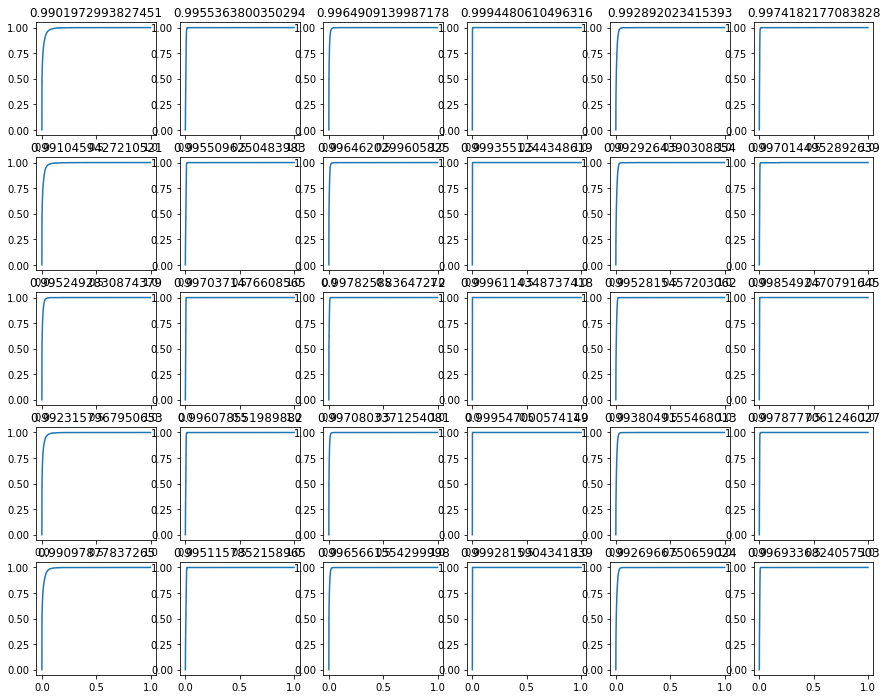

In [54]:
# reponse from each of the methods
train_responses = [train_sub_c, train_sub_w, train_sub_j, train_sub_mean, train_sub_max]

plt.figure(figsize=(15, 12))
plot_index = 1

for response in train_responses:
    # accumulate auroc on all targets
    acc_auroc = 0
    for t in targets:
        # true tags for this target
        y = train_data[t].values
        y_hat = response[t]
        
        plt.subplot(len(train_responses), len(targets), plot_index)
        roc_curve(y.ravel(), y_hat.ravel())
        acc_auroc += roc_auc_score(y, y_hat)
        fpr, tpr, _ = roc_curve(y, y_hat)
        plt.plot(fpr, tpr)
        plt.title(str(roc_auc_score(y, y_hat)))
        
        plot_index += 1

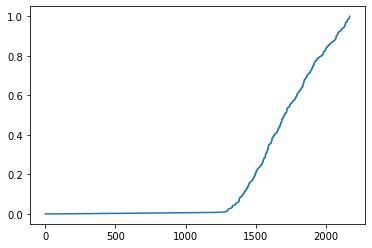

In [57]:
plt.plot(range(len(fpr)), fpr)

## Write submission files

In [47]:
sub_c.to_csv('../submissions/char.csv', index=0)
sub_w.to_csv('../submissions/word.csv', index=0)
sub_j.to_csv('../submissions/joint.csv', index=0)
sub_mean.to_csv('../submissions/mean.csv', index=0)
sub_max.to_csv('../submissions/max.csv', index=0)

In [64]:
zeros = pd.DataFrame({'id': test_data['id']})
for t in targets:
    zeros[t] = 0
zeros.to_csv("../submissions/zeros.csv", index=0)